# Do some scatter plots on the editC (epsilon score) 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import glob
import os
from scipy import stats
from tqdm import tnrange, tqdm_notebook

### For rebuttal - look at the outputs from just the CDS.

In [2]:
output_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/window_outputs_deep_cds_only/'

# This is where either scored_edits.txt or scored_edits_cds_only.txt are, which are compilations of all escores for all genes for all samples
bulk_input_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/window_outputs_cds_only/'
sc_input_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/window_outputs_deep_cds_only/'

# This is to select which samples we are to use to pull escores from
sc_escore_key = 'RPS2-STAMP_possorted_genome_bam_MD-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt'
bulk_escore_key = 'RPS2-1000_S18_L002_R1_001'
# bulk_escore_key = 'RPS2-1000_S18_L002_R1_001_a0_b0_e0.01.noRmDup.annotated.exons.merged.txt'

# This is to filter for genes that are expressed
sc_expr_counts = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/for_featurecounts/counts.txt'
bulk_expr_counts = '/home/bay001/projects/kris_apobec_20200121/permanent_data/20191003_riboseq/featurecounts/counts.txt' # for RBFOX2 and RPS2
# sc_expr_counts = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/for_featurecounts/counts.cds_only.txt'
# bulk_expr_counts = '/home/bay001/projects/kris_apobec_20200121/permanent_data/20191003_riboseq/featurecounts/counts.cds_only.txt' # for RBFOX2 and RPS2

# This is to select which samples we are to use to filter expression
# bulk_expr_key = 'results/RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam'
bulk_expr_key = 'results/RPS2-1000_S18_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam'
sc_expr_key = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.bam'

### Convert expression to TPM and filter to get only genes that are expressed

In [3]:
def counts_to_rpkm(feature_counts_table):
    """
    takes featureCounts counts.txt and returns RPKM
    """
    counts = feature_counts_table.ix[:,5:]
    lengths = feature_counts_table['Length']
    mapped_reads = counts.sum()
    return (counts * pow(10,9)).div(mapped_reads, axis=1).div(lengths, axis=0)

def counts_to_tpm(counts_table, skip_col=5):
    """
    simple function that converts a featureCounts pandas Dataframe
    into a TPM dataframe.
    
    :param counts_table: pandas.DataFrame() 
        either a featureCounts table (first five cols contain non-count info,
        the rest contain raw counts) or a generic counts table (use skip_col=0
        in this case)
    :return tpm: pandas.DataFrame
    """
    rpkm = counts_to_rpkm(counts_table)
    tpm = rpkm.div(rpkm.sum())*pow(10,6)
    return tpm

counts_table = pd.read_csv(bulk_expr_counts, sep='\t', index_col=0, skiprows=1)
counts_table = counts_table[['Chr','Start','End','Strand','Length', bulk_expr_key]]
counts_table.head()

,Chr,Start,End,Strand,Length,results/RPS2-1000_S18_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam
Geneid,,,,,,
ENSG00000223972.4,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,11869;11872;11874;12010;12179;12595;12613;1261...,12227;12227;12227;12057;12227;12721;12697;1272...,+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+,1756,0
ENSG00000227232.4,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,14363;14363;14363;14404;14411;14970;14970;1497...,14829;14829;14829;14501;14502;15038;15038;1503...,-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;...,2073,97
ENSG00000243485.2,chr1;chr1;chr1;chr1;chr1;chr1,29554;30267;30366;30564;30976;30976,30039;30667;30503;30667;31109;31097,+;+;+;+;+;+,1021,0
ENSG00000237613.2,chr1;chr1;chr1;chr1;chr1,34554;35245;35277;35721;35721,35174;35481;35481;36081;36073,-;-;-;-;-,1219,0
ENSG00000268020.2,chr1;chr1;chr1,52473;53049;54830,53312;53067;54936,+;+;+,947,7


In [4]:
sc_counts_table = pd.read_csv(sc_expr_counts, sep='\t', index_col=0, skiprows=1)
sc_counts_table = sc_counts_table[['Chr','Start','End','Strand','Length', sc_expr_key]]
sc_counts_table.head()

,Chr,Start,End,Strand,Length,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.bam
Geneid,,,,,,
ENSG00000223972.4,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,11869;11872;11874;12010;12179;12595;12613;1261...,12227;12227;12227;12057;12227;12721;12697;1272...,+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+,1756,0
ENSG00000227232.4,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,14363;14363;14363;14404;14411;14970;14970;1497...,14829;14829;14829;14501;14502;15038;15038;1503...,-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;...,2073,0
ENSG00000243485.2,chr1;chr1;chr1;chr1;chr1;chr1,29554;30267;30366;30564;30976;30976,30039;30667;30503;30667;31109;31097,+;+;+;+;+;+,1021,0
ENSG00000237613.2,chr1;chr1;chr1;chr1;chr1,34554;35245;35277;35721;35721,35174;35481;35481;36081;36073,-;-;-;-;-,1219,0
ENSG00000268020.2,chr1;chr1;chr1,52473;53049;54830,53312;53067;54936,+;+;+,947,0


In [5]:
def get_num_exons_from_featurecounts_row(row):
    n_exons = len(row['Chr'].split(';'))
    assert len(row['Chr'].split(';')) == len(row['Start'].split(';'))
    return n_exons

counts_table['n_exons'] = counts_table.apply(get_num_exons_from_featurecounts_row, axis=1)
sc_counts_table['n_exons'] = sc_counts_table.apply(get_num_exons_from_featurecounts_row, axis=1)

sc_counts_table.head()

,Chr,Start,End,Strand,Length,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.bam,n_exons
Geneid,,,,,,,
ENSG00000223972.4,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,11869;11872;11874;12010;12179;12595;12613;1261...,12227;12227;12227;12057;12227;12721;12697;1272...,+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+,1756,0,16
ENSG00000227232.4,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,14363;14363;14363;14404;14411;14970;14970;1497...,14829;14829;14829;14501;14502;15038;15038;1503...,-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;...,2073,0,55
ENSG00000243485.2,chr1;chr1;chr1;chr1;chr1;chr1,29554;30267;30366;30564;30976;30976,30039;30667;30503;30667;31109;31097,+;+;+;+;+;+,1021,0,6
ENSG00000237613.2,chr1;chr1;chr1;chr1;chr1,34554;35245;35277;35721;35721,35174;35481;35481;36081;36073,-;-;-;-;-,1219,0,5
ENSG00000268020.2,chr1;chr1;chr1,52473;53049;54830,53312;53067;54936,+;+;+,947,0,3


In [6]:
n_exon_cutoff = 2000000. # Some large number to include all genes. No gene has this many exons

print("before filtering out genes with lots of exons: ", counts_table.shape[0], sc_counts_table.shape[0])

counts_table = counts_table[counts_table['n_exons'] <= n_exon_cutoff]
sc_counts_table = sc_counts_table[sc_counts_table['n_exons'] <= n_exon_cutoff]

del counts_table['n_exons']
del sc_counts_table['n_exons']

print("after filtering out genes with lots of exons: ", counts_table.shape[0], sc_counts_table.shape[0])

before filtering out genes with lots of exons:  57820 57820
after filtering out genes with lots of exons:  57820 57820


In [7]:
tpm = counts_to_tpm(counts_table)
sc_tpm = counts_to_tpm(sc_counts_table)

tpm.sort_values(by=[bulk_expr_key], inplace=True, ascending=False)
sc_tpm.sort_values(by=[sc_expr_key], inplace=True, ascending=False)

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


#### Let's get anything that's expressed (tpm > 0)

In [8]:
tpm_cutoff = 0
bulk_expressed_genes = tpm[tpm[bulk_expr_key] > tpm_cutoff].index
sc_expressed_genes = sc_tpm[sc_tpm[sc_expr_key] > tpm_cutoff].index
print(len(bulk_expressed_genes), len(sc_expressed_genes))

23754 20822


In [9]:
n = 100  # if we wanted to select only the top N genes by expression for comparison

def get_topn_percent_expressed(df, column, n):
    """
    Returns the index of the top n% of a given column.
    """
    n_tot = df.shape[0]
    n_top = int(n_tot * (n/100.))
    print("returning the top {} out of {} ({}%)".format(n_top, n_tot, n))
    return df.sort_values(by=column, ascending=False)[:n_top].index
    
top_bulk_expressed_genes = get_topn_percent_expressed(df=tpm[tpm[bulk_expr_key] > tpm_cutoff], column=bulk_expr_key, n=n)
top_sc_expressed_genes = get_topn_percent_expressed(df=sc_tpm[sc_tpm[sc_expr_key] > tpm_cutoff], column=sc_expr_key, n=n)

returning the top 23754 out of 23754 (100%)
returning the top 20822 out of 20822 (100%)


In [10]:
# if we want to use only the top n % expressed
expressed_genes = set(top_bulk_expressed_genes).intersection(set(top_sc_expressed_genes))
len(expressed_genes)

17799

In [11]:
merged_expressed = pd.merge(tpm.loc[expressed_genes], sc_tpm.loc[expressed_genes], how='outer', left_index=True, right_index=True)
merged_expressed['l2_sc'] = np.log2(merged_expressed[sc_expr_key])
merged_expressed['l2_bulk'] = np.log2(merged_expressed[bulk_expr_key])
merged_expressed.sort_values(by=['l2_sc','l2_bulk'], ascending=False, inplace=True)
merged_expressed.head()

,results/RPS2-1000_S18_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.bam,l2_sc,l2_bulk
Geneid,,,,
ENSG00000112306.7,6987.673257,18613.962307,14.184098,12.770596
ENSG00000197061.3,10.520058,14267.301769,13.800425,3.395071
ENSG00000231500.2,6770.028340,11321.695085,13.466802,12.724946
ENSG00000140988.11,12495.142640,11129.728299,13.442131,13.609080
ENSG00000162244.6,5021.621623,10999.884303,13.425201,12.293938


In [12]:
def r2spearman(x, y):
    return stats.spearmanr(x, y)[0] ** 2

def r2pearson(x, y):
    return stats.pearsonr(x, y)[0] ** 2

def plot_correlation(df, col1, col2, stat_func, output_dir):
    plot = sns.jointplot(
        x=col1, 
        y=col2, 
        data=df, 
        kind="reg", 
        stat_func=stat_func,
        xlim=(df.min().min(), df.max().max()), 
        ylim=(df.min().min(), df.max().max())
    )
    plot.savefig(os.path.join(output_dir, '{}.{}.png'.format(os.path.basename(col1), os.path.basename(col2))))
    plot.savefig(os.path.join(output_dir, '{}.{}.png'.format(os.path.basename(col1), os.path.basename(col2))))

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/seaborn/axisgrid.py:1741: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()
/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


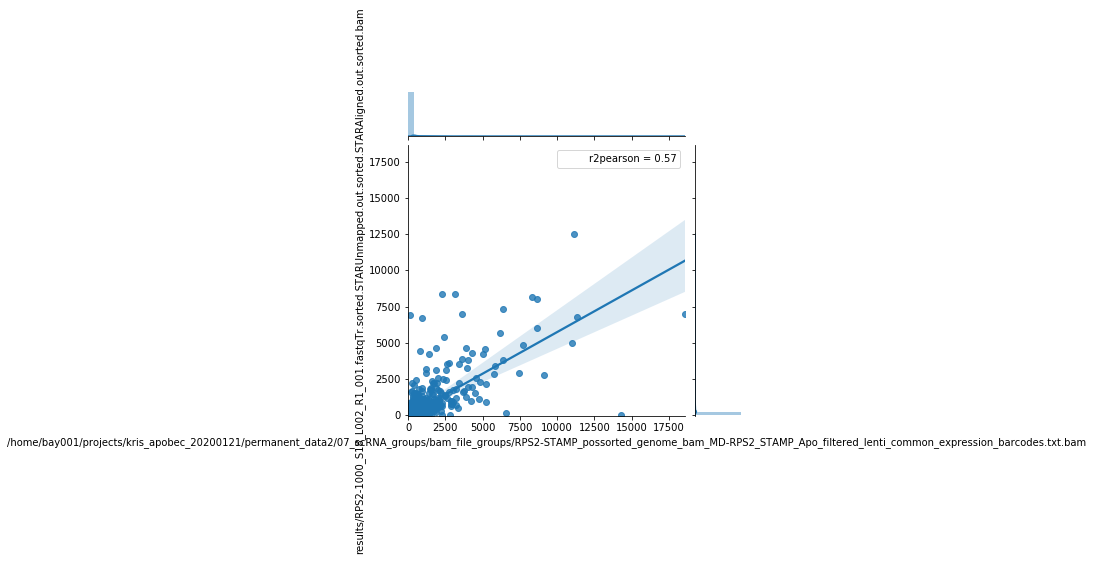

In [13]:
plot_correlation(
    df=merged_expressed,
    col1=sc_expr_key,
    col2=bulk_expr_key,
    stat_func=r2pearson,
    output_dir=output_dir,
)

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log2
  


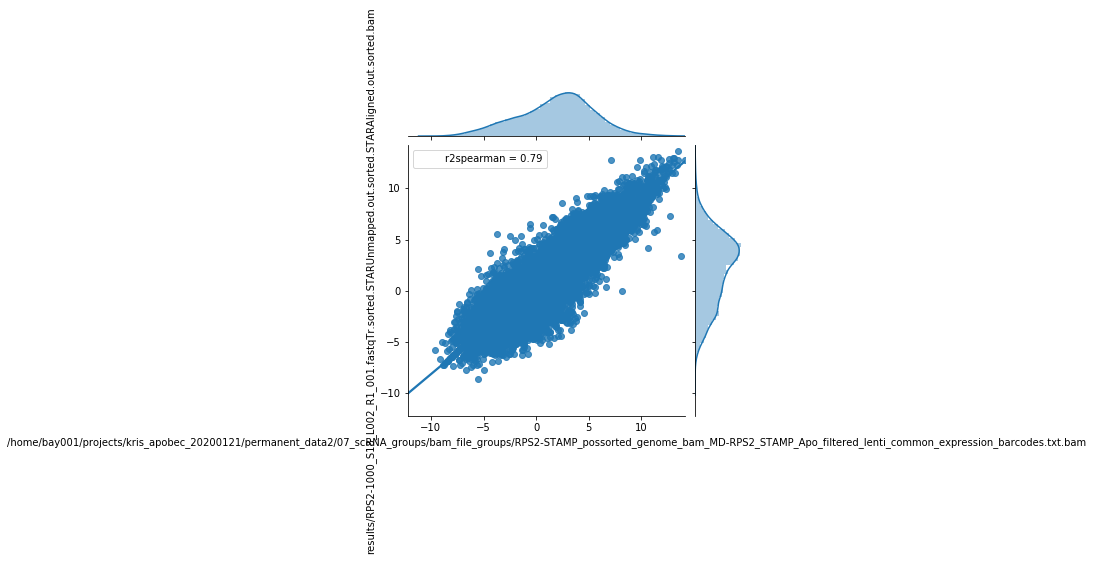

In [14]:
plot_correlation(
    df=np.log2(merged_expressed),
    col1=sc_expr_key,
    col2=bulk_expr_key,
    stat_func=r2spearman,
    output_dir=output_dir,
)

### Use scored_edits.txt from 12_combine_scored_windows_from_11.ipynb
- 2020-12-04 use scored_edits_cds_only.txt

In [15]:
# sc_editc = pd.read_csv(os.path.join(sc_input_dir, 'scored_edits.txt'), sep='\t', index_col=0)
sc_editc = pd.read_csv(os.path.join(sc_input_dir, 'scored_edits_cds_only.txt'), sep='\t', index_col=0)
sc_editc.head()

,APOBEC-STAMP_possorted_genome_bam-APOBEC_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt,APOBEC-STAMP_possorted_genome_bam_MD,APOBEC-STAMP_possorted_genome_bam_MD-1_barcodes.tsv,APOBEC-STAMP_possorted_genome_bam_MD-2_barcodes.tsv,APOBEC-STAMP_possorted_genome_bam_MD-5_barcodes.tsv,For_Motif_ALL_edits_barcodes_0_1,For_Motif_Background_APO_plus_RBFOX2-TIA1_APO_edits_barcodes_4_5,HEK-NPC-APOBEC-STAMP_possorted_genome_bam_MD-19_barcodes.tsv,HEK-NPC-APOBEC-STAMP_possorted_genome_bam_MD-20_barcodes.tsv,HEK-NPC-RBFOX2-STAMP_possorted_genome_bam_MD-21_barcodes.tsv,...,RBFOX2-TIA1-STAMP_round2E_read1_feature_FB_possorted_genome_bam_MD-7_barcodes_noCS.rand100.txt,RBFOX2-TIA1-STAMP_round2E_read1_feature_FB_possorted_genome_bam_MD-7_barcodes_noCS.rand200.txt,RBFOX2-TIA1-STAMP_round2E_read1_feature_FB_possorted_genome_bam_MD-7_barcodes_noCS.rand300.txt,RBFOX2-TIA1-STAMP_round2E_read1_feature_FB_possorted_genome_bam_MD-7_barcodes_noCS.rand50.txt,RBFOX2-TIA1-STAMP_round2E_read1_feature_FB_possorted_genome_bam_MD-7_barcodes_noCS.rand500.txt,RBFOX2-TIA1-STAMP_round2E_read1_feature_FB_possorted_genome_bam_MD-7_barcodes_noCS.txt,RPS2-STAMP_possorted_genome_bam-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt,RPS2-STAMP_possorted_genome_bam_MD,RPS2-STAMP_possorted_genome_bam_MD-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt,RPS2-STAMP_possorted_genome_bam_MD-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.downsampled50M
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.10,0.000369,0.000326,0.000327,0.000327,0.000328,0.000705,0.000364,0.000323,0.000000,0.001020,...,0.003802,0.000000,0.000000,0.0,0.001580,0.001512,0.003505,0.001367,0.003220,0.001088
ENSG00000000419.8,0.000226,0.000193,0.000234,0.000234,0.000234,0.001502,0.000552,0.000000,0.000575,0.000000,...,0.004283,0.001037,0.003075,0.0,0.001870,0.002743,0.004926,0.002090,0.004749,0.004668
ENSG00000000457.9,0.000663,0.000452,0.000888,0.000888,0.000894,0.000389,0.000498,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000833,0.000000,0.000000
ENSG00000000460.12,0.000355,0.000359,0.000329,0.000329,0.000330,0.000664,0.000423,0.000000,0.000930,0.000618,...,0.000000,0.000000,0.002302,0.0,0.001591,0.000999,0.001428,0.000835,0.001366,0.001559
ENSG00000000938.8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [16]:
for c in sc_editc.columns:
    print(c)

APOBEC-STAMP_possorted_genome_bam-APOBEC_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt
APOBEC-STAMP_possorted_genome_bam_MD
APOBEC-STAMP_possorted_genome_bam_MD-1_barcodes.tsv
APOBEC-STAMP_possorted_genome_bam_MD-2_barcodes.tsv
APOBEC-STAMP_possorted_genome_bam_MD-5_barcodes.tsv
For_Motif_ALL_edits_barcodes_0_1
For_Motif_Background_APO_plus_RBFOX2-TIA1_APO_edits_barcodes_4_5
HEK-NPC-APOBEC-STAMP_possorted_genome_bam_MD-19_barcodes.tsv
HEK-NPC-APOBEC-STAMP_possorted_genome_bam_MD-20_barcodes.tsv
HEK-NPC-RBFOX2-STAMP_possorted_genome_bam_MD-21_barcodes.tsv
HEK-NPC-RBFOX2-STAMP_possorted_genome_bam_MD-22_barcodes.tsv
HEK-NPC-RBFOX2-STAMP_possorted_genome_bam_MD-23_barcodes.tsv
HEK-NPC-RBFOX2-STAMP_possorted_genome_bam_MD-24_barcodes.tsv
HEK-NPC-RBFOX2-STAMP_possorted_genome_bam_MD-25_barcodes.tsv
HEK-NPC-RBFOX2-STAMP_possorted_genome_bam_MD-26_barcodes.tsv
HEK-NPC-RBFOX2-STAMP_possorted_genome_bam_MD-30_barcodes.tsv
HEK-NPC-RBFOX2-STAMP_possorted_genome_bam_MD-31_barcodes.tsv
HE

In [17]:
# bulk_editc = pd.read_csv(os.path.join(bulk_input_dir, 'scored_edits.txt'), sep='\t', index_col=0)
bulk_editc = pd.read_csv(os.path.join(bulk_input_dir, 'scored_edits_cds_only.txt'), sep='\t', index_col=0)
bulk_editc.head()

,ApoControl-0_S7_L001_R1_001,ApoControl-1000_S21_L002_R1_001,ApoControl-1000_S21_L002_R1_001.21M,ApoControl-50_S14_L002_R1_001,Apobec-T_1_S28_L003_R1_001,Apobec-T_2_S29_L003_R1_001,Apobec_plusT_1_S30_L003_R1_001,Apobec_plusT_2_S31_L003_R1_001,RBFOX2-0_S6_L001_R1_001,RBFOX2-0_S6_L001_R1_001_a0_b0_e0.01_noRmDup.annotated.exons.merged.txt,...,TI_55_S13_L001_R1_001,TI_55_S13_L001_R1_001.10M,TI_56_S14_L001_R1_001,TI_58_S15_L001_R1_001,TI_58_S15_L001_R1_001.10M,TI_59_S16_L001_R1_001,TI_59_S16_L001_R1_001.10M,TI_5_S4_L001_R1_001,TI_7_S5_L001_R1_001,TI_8_S6_L001_R1_001
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.10,0.000000,0.000205,0.000289,0.000224,0.000203,0.000000,0.000000,0.000000,0.000000,0.000165,...,0.001037,0.000385,0.001589,0.002108,0.001718,0.000982,0.001337,0.000259,0.000323,0.000438
ENSG00000000419.8,0.000230,0.000488,0.000346,0.000283,0.000000,0.000000,0.000000,0.000000,0.000233,0.000174,...,0.001040,0.001449,0.000835,0.000000,0.000000,0.001172,0.001288,0.000000,0.000674,0.000000
ENSG00000000457.9,0.000409,0.000000,0.000000,0.000000,0.000327,0.000264,0.000496,0.000560,0.000643,0.000493,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000506,0.000000,0.000244
ENSG00000000460.12,0.000253,0.000592,0.000561,0.000485,0.000116,0.000341,0.000350,0.000224,0.000000,0.000141,...,0.000449,0.000000,0.000598,0.000000,0.000000,0.000575,0.000482,0.000449,0.000542,0.000317
ENSG00000001036.9,0.000263,0.000777,0.000944,0.000176,0.000243,0.000125,0.000153,0.000000,0.000077,0.000126,...,0.000479,0.000186,0.000891,0.001174,0.001053,0.001540,0.001292,0.000000,0.000373,0.000310


In [18]:
counter = 0
for c in bulk_editc.columns:
    print(c)

ApoControl-0_S7_L001_R1_001
ApoControl-1000_S21_L002_R1_001
ApoControl-1000_S21_L002_R1_001.21M
ApoControl-50_S14_L002_R1_001
Apobec-T_1_S28_L003_R1_001
Apobec-T_2_S29_L003_R1_001
Apobec_plusT_1_S30_L003_R1_001
Apobec_plusT_2_S31_L003_R1_001
RBFOX2-0_S6_L001_R1_001
RBFOX2-0_S6_L001_R1_001_a0_b0_e0.01_noRmDup.annotated.exons.merged.txt
RBFOX2-1000_S20_L002_R1_001
RBFOX2-1000_S20_L002_R1_001_a0_b0_e0.01_noRmDup.annotated.exons.merged.txt
RBFOX2-50_S13_L002_R1_001
RBFOX2-50_S13_L002_R1_001_a0_b0_e0.01_noRmDup.annotated.exons.merged.txt
RBFOX2-T_1_S32_L003_R1_001
RBFOX2-T_2_S33_L003_R1_001
RBFOX2_plusT_1_S34_L003_R1_001
RBFOX2_plusT_2_S35_L003_R1_001
RPS2-0_S4_L001_R1_001
RPS2-0_S4_L001_R1_001_a0_b0_e0.01.noRmDup.annotated.exons.merged.txt
RPS2-1000_S18_L002_R1_001
RPS2-1000_S18_L002_R1_001.21M
RPS2-1000_S18_L002_R1_001_a0_b0_e0.01.noRmDup.annotated.exons.merged.txt
RPS2-50_S11_L001_R1_001
RPS2-50_S11_L001_R1_001_a0_b0_e0.01.noRmDup.annotated.exons.merged.txt
RPS2-T_1_S36_L003_R1_001
RPS2-

#### escore counts are not comprehensive - will only contain the escores of genes that have had measurable editing in any dataset and not necessarily all genes that were expressed. We can correct this by outer join and filling missing values with 0 (no editing)

In [19]:
merged = pd.merge(
    bulk_editc, 
    sc_editc, 
    how='outer', 
    left_index=True, 
    right_index=True
)
merged.fillna(0, inplace=True)
merged = merged[[sc_escore_key, bulk_escore_key]]
# merged = merged[(merged[col1]>0) | (merged[col2]>0)]
print(merged.shape[0])
merged.head()

15659


,RPS2-STAMP_possorted_genome_bam_MD-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt,RPS2-1000_S18_L002_R1_001
Geneid,,
ENSG00000000003.10,0.003220,0.017830
ENSG00000000419.8,0.004749,0.014012
ENSG00000000457.9,0.000000,0.001125
ENSG00000000460.12,0.001366,0.008949
ENSG00000000938.8,0.000000,0.000000


In [20]:
merged_expressed_only = merged.loc[expressed_genes]
print(merged_expressed_only.shape[0])

17799


/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [21]:
merged_expressed_only.fillna(0, inplace=True)
print(merged_expressed_only.shape[0])
merged_expressed_only.head()

17799


,RPS2-STAMP_possorted_genome_bam_MD-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt,RPS2-1000_S18_L002_R1_001
Geneid,,
ENSG00000196975.10,0.002045,0.009415
ENSG00000159720.7,0.000704,0.004884
ENSG00000249568.1,0.000000,0.000000
ENSG00000102302.7,0.000000,0.000766
ENSG00000137207.7,0.001161,0.003461


In [22]:
sc_not_bulk = merged_expressed_only[(merged_expressed_only[sc_escore_key]>0) & (merged_expressed_only[bulk_escore_key]==0)]
bulk_not_sc = merged_expressed_only[(merged_expressed_only[bulk_escore_key]>0) & (merged_expressed_only[sc_escore_key]==0)]
print(sc_not_bulk.shape[0], bulk_not_sc.shape[0])

728 2191


In [23]:
# Pseudocount to remove inf values upon log2 transformation
# ps = min(min(merged_expressed_only[merged_expressed_only != 0][sc_escore_key]), min(merged_expressed_only[merged_expressed_only != 0][bulk_escore_key]))
ps = min(merged_expressed_only[merged_expressed_only > .0].min(axis=1).dropna())
ps

2.8297748914073886e-06

In [24]:
merged_expressed_only += ps

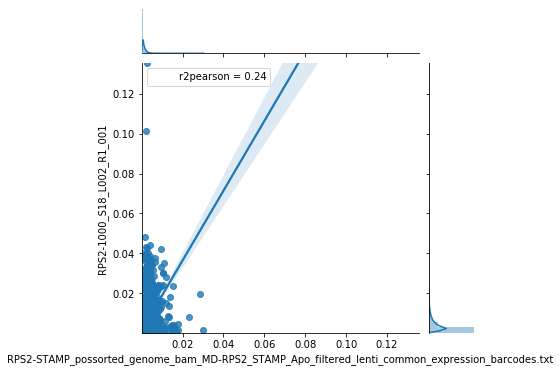

In [25]:
plot_correlation(
    df=merged_expressed_only,
    col1=sc_escore_key,
    col2=bulk_escore_key,
    stat_func=r2pearson,
    output_dir=output_dir,
)

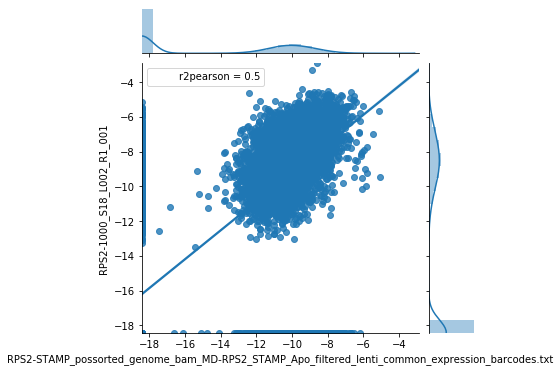

In [26]:
plot_correlation(
    df=np.log2(merged_expressed_only),
    col1=sc_escore_key,
    col2=bulk_escore_key,
    stat_func=r2pearson,
    output_dir=output_dir,
)

# Investigate some of the biggest differential editing events

In [27]:
merged_expressed_only['diff'] = merged_expressed_only[sc_escore_key] - merged_expressed_only[bulk_escore_key]
merged_expressed_only_w_exprs = pd.merge(merged_expressed_only, merged_expressed, how='outer', left_index=True, right_index=True)
# merged_expressed_only_w_exprs.sort_values(by='diff', ascending=False).head(100)
merged_expressed_only_w_exprs.to_csv('/projects')

,RPS2-STAMP_possorted_genome_bam_MD-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt,RPS2-1000_S18_L002_R1_001,diff,results/RPS2-1000_S18_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.bam,l2_sc,l2_bulk
Geneid,,,,,,,
ENSG00000182541.13,0.030046,0.001396,0.028650,7.783479,6.147578,2.620018,2.960415
ENSG00000227124.4,0.017723,0.001637,0.016085,5.809661,1.169914,0.226403,2.538454
ENSG00000058404.15,0.017018,0.000975,0.016043,1.459345,2.118341,1.082935,0.545321
ENSG00000106066.9,0.022936,0.007892,0.015045,62.177941,50.570622,5.660228,5.958331
ENSG00000136237.14,0.016315,0.001933,0.014381,4.183939,1.469237,0.555068,2.064862
ENSG00000171444.13,0.014685,0.000882,0.013803,1.628199,0.928250,-0.107414,0.703277
ENSG00000074211.9,0.014999,0.001351,0.013648,4.552318,0.988405,-0.016826,2.186601
ENSG00000221994.6,0.013516,0.000003,0.013514,1.274527,0.172925,-2.531785,0.349962
ENSG00000136891.9,0.017842,0.004699,0.013143,24.935897,10.268149,3.360104,4.640152


In [28]:
merged_expressed_only_w_exprs[(np.abs(merged_expressed_only_w_exprs['diff'])<0.0001)].sort_values(by=bulk_escore_key, ascending=False)

,RPS2-STAMP_possorted_genome_bam_MD-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt,RPS2-1000_S18_L002_R1_001,diff,results/RPS2-1000_S18_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.bam,l2_sc,l2_bulk
Geneid,,,,,,,
ENSG00000058729.6,0.013526,0.013489,3.707958e-05,20.053851,21.026875,4.394163,4.325807
ENSG00000143320.4,0.004742,0.004735,7.475294e-06,186.449561,25.309240,4.661592,7.542642
ENSG00000167515.6,0.004523,0.004576,-5.291544e-05,20.876240,141.466645,7.144318,4.383790
ENSG00000085662.9,0.004458,0.004457,6.411587e-07,270.803642,200.346621,7.646354,8.081103
ENSG00000106268.11,0.004472,0.004388,8.438375e-05,42.241615,214.568091,7.745292,5.400593
ENSG00000168938.5,0.003752,0.003839,-8.711317e-05,64.556614,131.412874,7.037963,6.012493
ENSG00000163399.11,0.003808,0.003781,2.699935e-05,494.462899,75.120153,6.231128,8.949718
ENSG00000105669.8,0.003688,0.003701,-1.325021e-05,86.429150,322.258217,8.332073,6.433446
ENSG00000115840.9,0.003621,0.003539,8.191180e-05,10.711277,6.758253,2.756650,3.421059
